### Imports

In [1]:
import h5py
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
data = h5py.File("data/CH_D3.jld2", "r")

### Config

In [2]:
input_size = output_size = 10_000
seq_length = 100
batch_size = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_index = 260
loss_func = nn.MSELoss()

### Dataloading and Preping

In [3]:
X1_CH = torch.Tensor(np.array(data["X1"]))
X2_CH = torch.Tensor(np.array(data["X2"]))
X3_CH = torch.Tensor(np.array(data["X3"]))

y1 = X1_CH[101:, :]
y2 = X2_CH[101:, :]
y3 = X3_CH[101:, :]
X1 = torch.stack([X1_CH[i:i+100, :] for i in range(1, 301)])
X2 = torch.stack([X2_CH[i:i+100, :] for i in range(1, 301)])
X3 = torch.stack([X3_CH[i:i+100, :] for i in range(1, 301)])

y1_train = y1[:train_index, :]
y1_test = y1[train_index:, :]
X1_train = X1[:train_index, :, :]
X1_test = X1[train_index:, :, :]
y2_train = y2[:train_index, :]
y2_test = y2[train_index:, :]
X2_train = X2[:train_index, :, :]
X2_test = X2[train_index:, :, :]
y3_train = y3[:train_index, :]
y3_test = y3[train_index:, :]
X3_train = X3[:train_index, :, :]
X3_test = X3[train_index:, :, :]

dt_CH = 0.1

In [4]:
# Shapes:
# X: (300, 100, 10_000)
# y: (300, 10_000)

In [5]:
class X1Trajectories(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [6]:
train_set_x1 = X1Trajectories(X1_train, y1_train)
test_set_x1 = X1Trajectories(X1_test, y1_test)
train_loader_x1 = DataLoader(train_set_x1, batch_size=batch_size, shuffle=True)
test_loader_x1 = DataLoader(test_set_x1, batch_size=batch_size, shuffle=False)

train_set_x2 = X1Trajectories(X2_train, y2_train)
test_set_x2 = X1Trajectories(X2_test, y2_test)
train_loader_x2 = DataLoader(train_set_x2, batch_size=batch_size, shuffle=True)
test_loader_x2 = DataLoader(test_set_x2, batch_size=batch_size, shuffle=False)

train_set_x3 = X1Trajectories(X3_train, y3_train)
test_set_x3 = X1Trajectories(X3_test, y3_test)
train_loader_x3 = DataLoader(train_set_x3, batch_size=batch_size, shuffle=True)
test_loader_x3 = DataLoader(test_set_x3, batch_size=batch_size, shuffle=False)

### Model architecture

In [7]:
class PINN(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        # input shape: (Batch, Seq_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.h0 = torch.zeros(num_layers, batch_size, hidden_size).to(device)
        self.c0 = torch.zeros(num_layers, batch_size, hidden_size).to(device)

    def forward(self, x):
        out, _ = self.lstm(x, (self.h0, self.c0))
        out = f.tanh(self.fc(out[:,-1,:]))
        return out


In [8]:
model_x1 = torch.load("LSTM_X1")
model_x2 = torch.load("LSTM_X2")
model_x3 = torch.load("LSTM_X3")


/tmp/ipykernel_1383636/3514317213.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_x1 = torch.load("LSTM_X1")
/tmp/ipykernel_1383636/3514317213.py:2: FutureWarning:

### Training

In [9]:
#loss_func = nn.MSELoss() # + PDE informed loss
#lr = 1e-3
#num_epochs = 4
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [10]:
#for epoch in range(num_epochs):
#    model.train(True)
#    print(f"Starting epoch: {epoch + 1}")
#    print(f"*******************************")
#    running_loss = 0.0
#    epoch_loss = 0.0
#
#    for i, batch in enumerate(train_loader):
#        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
#        y_pred = model(X_batch)
#        loss = loss_func(y_pred, y_batch)
#        running_loss += loss
#        epoch_loss += loss
#        
#        optimizer.zero_grad()
#        loss.backward()
#        optimizer.step()
#
#        if i % 5 == 0 and i > 0:
#            avg_loss = running_loss / 5
#            print(f"Batch {i}, Loss: {avg_loss : .3f}")
#            running_loss = 0.0
#    
#    epoch_loss /= len(train_loader)
#    print(f"Average Loss over epoch: {epoch_loss: .3f}")
#    print(f"*******************************")

### save model

In [11]:
#torch.save(model.state_dict(), "First_LSTM_test_params")

### evaluate

In [12]:
def eval_model(test_loader, model, loss_func, verbose=True):
    model.train(False)
    running_loss = 0.0

    for i, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            running_loss += loss

    avg_loss = running_loss / (i+1)

    if verbose:
        print(f"Val loss: {avg_loss: .3f}")
    
    return avg_loss

In [13]:
print(f"X1: {eval_model(test_loader_x1, model_x1, loss_func, verbose=False) : .3f}")
print(f"X2: {eval_model(test_loader_x2, model_x2, loss_func, verbose=False) : .3f}")
print(f"X3: {eval_model(test_loader_x3, model_x3, loss_func, verbose=False) : .3f}")

X1:  0.014
X2:  0.016
X3:  0.025


In [ ]:
import matplotlib.pyplot as plt

In [18]:
plt.imshow(y_pred[1,:].reshape(100, 100).to("cpu"))

NameError: name 'y_pred' is not defined

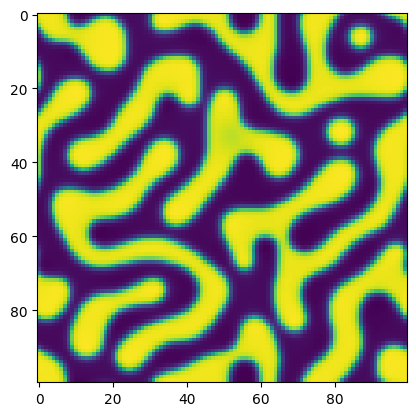

In [27]:
plt.imshow(y1_test[-1,:].reshape(100, 100))